## Structure Generation
The end result of these cells will be a set of computed force constants and everything needed to initialize a kALDO `Phonons` object. 

For the purposes of MgO rock salt (a very harmonic crystal), we will define the structure with `ase` and perform MD calculations in LAMMPS to get the second- and third-order force constants. We will use start with a fit Buckingham potential from https://www.sciencedirect.com/science/article/pii/S0022311508003632?via%3Dihub

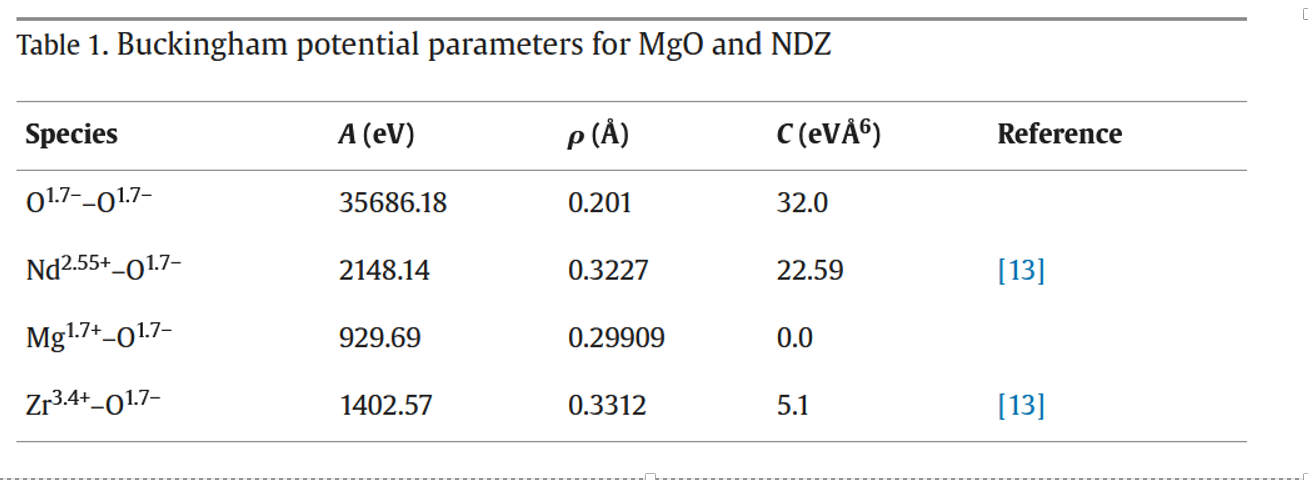

3x4x5 dft supercell
4x4x4 x 3x4x5 md supercell

In [1]:
from ase.build import bulk
from ase.calculators.lammpslib import LAMMPSlib
from kaldo.forceconstants import ForceConstants
import numpy as np

import logging

logging.basicConfig(level=logging.INFO)

# we will eventually need to ensure these lattice parameters are minimized
a = 4.212
atoms = bulk('MgO', 'rocksalt', a=a)

# as given by paper
atoms.set_initial_charges([1.7, -1.7])

# specify atom types and numbers for LAMMPS
atom_types = {'Mg': 1, 'O': 2}

In [2]:
# from ase.visualize import view
# view(atoms)
print(atoms.get_initial_charges())
l1, l2, l3 = atoms.cell
norm = np.linalg.norm(l1)
print(f"cubic lattice constant: a = {norm * np.sqrt(2)}A")

[ 1.7 -1.7]
cubic lattice constant: a = 4.212A


In [3]:
from kaldo.conductivity import Conductivity
from kaldo.phonons import Phonons
import pandas as pd

# replicate mgo paper

lammps_inputs = {
    'lammps_header': ['units metal',
    'atom_style charge', 'atom_modify map array sort 0 0'],

      'lmpcmds': [
          'kspace_style pppm 1.0e-6',
          'pair_style buck/coul/long 10.0',
          'pair_coeff 1 1 0 1 0',
          'pair_coeff 2 2 35686.18 0.201 32.0',
          'pair_coeff 1 2 929.69 0.29909 0.0'],

      'log_file': 'lammps-MgO-bulk.log',
      'keep_alive':True}

atoms.calc = LAMMPSlib(**lammps_inputs)

print("Energy ", atoms.get_potential_energy())

Energy  -29.859956313912768


In [4]:
from ase.filters import StrainFilter
from ase.optimize import BFGS
# relax structure
sf = StrainFilter(atoms)
dyn = BFGS(sf)


logging.info("Relaxing structure")
dyn.run(fmax=0.001)

l1, l2, l3 = atoms.cell
norm = np.linalg.norm(l1)
logging.info(f"cubic lattice constant: a = {norm * np.sqrt(2)}A")

INFO:root:Relaxing structure


      Step     Time          Energy          fmax
BFGS:    0 16:49:25      -29.859956        0.263993
BFGS:    1 16:49:25      -29.860515        0.031697
BFGS:    2 16:49:25      -29.860526        0.000283


INFO:root:cubic lattice constant: a = 4.201577473024488A


In [5]:
# buckingham potential 4x4x4 supercell
supercell = np.array([4, 4, 4])

# enlarged unit cell from paper
# supercell = np.array([4 * 3, 4 * 4, 4 * 5])

# Create a finite difference object
forceconstants_config  = {'atoms':atoms,'supercell': supercell,'folder':'force_constants'}
forceconstants = ForceConstants(**forceconstants_config)

# Compute 2nd and 3rd IFCs with LAMMPS using a tersoff potential
# delta_shift is how much to move atoms when computing forces
forceconstants.second.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)
forceconstants.third.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)

2025-10-30 16:49:25,941 - kaldo - WARNING - Directly use ForceConstants to load data from folder is discouraged with limit                             functionalities. Please use ForceConstants.from_folder for more options.


2025-10-30 16:49:25,949 - kaldo - INFO - Second order not found. Calculating.


INFO:kaldo:Second order not found. Calculating.


2025-10-30 16:49:25,950 - kaldo - INFO - Calculating second order potential derivatives, finite difference displacement: 1.000e-03 angstrom


INFO:kaldo:Calculating second order potential derivatives, finite difference displacement: 1.000e-03 angstrom


2025-10-30 16:49:26,309 - kaldo - INFO - Symmetry of Dynamical Matrix 0.0003838492412142596


INFO:kaldo:Symmetry of Dynamical Matrix 0.0003838492412142596


2025-10-30 16:49:26,314 - kaldo - INFO - force_constants\second stored


INFO:kaldo:force_constants\second stored


2025-10-30 16:49:26,373 - kaldo - INFO - Third order not found. Calculating.


INFO:kaldo:Third order not found. Calculating.


2025-10-30 16:49:26,374 - kaldo - INFO - Calculating third order potential derivatives, finite difference displacement: 1.000e-03 angstrom


INFO:kaldo:Calculating third order potential derivatives, finite difference displacement: 1.000e-03 angstrom


2025-10-30 16:57:22,719 - kaldo - INFO - total forces to calculate third : 2304


INFO:kaldo:total forces to calculate third : 2304


2025-10-30 16:57:22,721 - kaldo - INFO - forces calculated : 2304


INFO:kaldo:forces calculated : 2304


2025-10-30 16:57:22,723 - kaldo - INFO - forces skipped (outside distance threshold) : 0


INFO:kaldo:forces skipped (outside distance threshold) : 0


In [6]:
# Create phonons object

# k-sampling grid for conductivity cals
k=9
kpts = [k, k, k]
temperature = 300
is_classic = False # phonon mondes are treated as quantized
k_label = str(k) + '_' + str(k) + '_' + str(k)

phonons = Phonons(forceconstants=forceconstants,
                kpts=kpts,
                is_classic=is_classic,
                temperature=300,
                folder='si-bulk-ald-' + k_label,
                storage='numpy')


## Kappa calculation

In [7]:
from kaldo.conductivity import Conductivity
qhgk_cond_matrix = Conductivity(phonons=phonons, method='qhgk').conductivity.sum(axis=0)

rta_cond_matrix = Conductivity(phonons=phonons, method='rta', n_interations=0).conductivity.sum(axis=0)

cond_rta = float(np.mean(np.diag(rta_cond_matrix)))

cond_qhgk = float(np.mean(np.diag(qhgk_cond_matrix)))

inv_cond_matrix = Conductivity(phonons=phonons, method='inverse').conductivity.sum(axis=0)
cond_inv = float(np.mean(np.diag(inv_cond_matrix)))


2025-10-30 16:57:24,227 - kaldo - INFO - Loading si-bulk-ald-9_9_9/9_9_9/qhgk/300/quantum/conductivity


INFO:kaldo:Loading si-bulk-ald-9_9_9/9_9_9/qhgk/300/quantum/conductivity


2025-10-30 16:57:24,229 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-30 16:57:24,404 - kaldo - INFO - Loading si-bulk-ald-9_9_9/9_9_9/rta/300/quantum/conductivity


INFO:kaldo:Loading si-bulk-ald-9_9_9/9_9_9/rta/300/quantum/conductivity


2025-10-30 16:57:24,577 - kaldo - INFO - Loading si-bulk-ald-9_9_9/9_9_9/inverse/300/quantum/conductivity


INFO:kaldo:Loading si-bulk-ald-9_9_9/9_9_9/inverse/300/quantum/conductivity


In [8]:
print('RTA conductivity (W/mK): %.3f'%(cond_rta))
print(f'QHGK conductivity (W/mK): {cond_qhgk:.3f}')
print(f'inversion method conductivity (W/mK): {cond_inv:.3f}')

RTA conductivity (W/mK): 27.825
QHGK conductivity (W/mK): 41.726
inversion method conductivity (W/mK): 28.295


* Strange discrepancy for what should be a very harmonic crystal
* Possibly related to the structure not being perfectly relaxed?
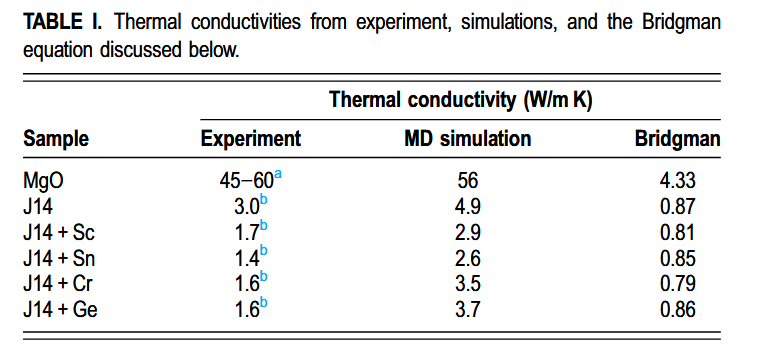

## Phonon Dispersion

C:\Users\allen\miniconda3\envs\phys449\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]
C:\Users\allen\miniconda3\envs\phys449\Lib\site-packages\kaldo\observables\harmonic_with_q.py:256: RuntimeWarning: invalid value encountered in sqrt
  inverse_sqrt_freq = tf.cast(tf.convert_to_tensor(1 / np.sqrt(frequency)), tf.complex128)


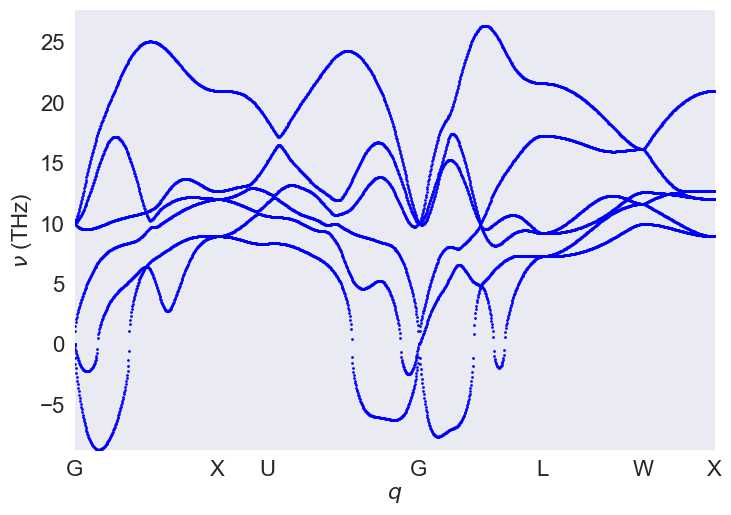

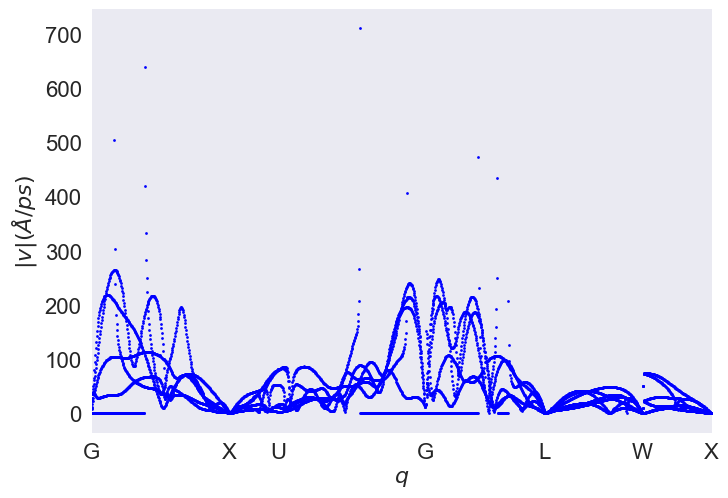

In [9]:
import kaldo.controllers.plotter as plotter
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Plot dispersion relation and group velocity in each direction
plotter.plot_dispersion(phonons,n_k_points=int(k_label))